# Power Rangers Solution

# Starting points

We have images with different cloth parts and we have to identify cloth id and attributes

We will use classical deep learning approach. We will use this [awesome framework](https://github.com/qubvel/segmentation_models.pytorch)

# pip installs

In [1]:
!pip install segmentation-models-pytorch

     |████████████████████████████████| 51kB 2.4MB/s 
     |████████████████████████████████| 61kB 4.8MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp36-none-any.whl size=60963 sha256=abd34ca6481e9097aaa94dfb2f14a5cc7e02de3e34008128ad687a0a7ec31811
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.1-cp36-none-any.whl size=12407 sha256=159858601a2126eedfd034bb7749e87d8160588bdf50f8c56384d16bb0c74ed9
  Stored in directory: /root/.cache/pip/wheels/0f/b0/79/1663bc9714b5d88deba05e44f593ce50111bd69305a45df87a
Successfully built pretrainedmodels efficientnet-pytorch


# Imports

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import cv2
import collections
import segmentation_models_pytorch as smp
import albumentations as albu
import torch
import seaborn as sns

from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from glob import glob
from os import path
from PIL import Image
from tqdm import tqdm
from matplotlib import pyplot as plt

%matplotlib inline

# Constants

In [3]:
ROOT_PATH_TRAIN = '/kaggle/input/imaterialist-fashion-2019-FGVC6/train'
DF_PATH_TRAIN = '/kaggle/input/imaterialist-fashion-2019-FGVC6/train.csv'
PATH_TO_MODEL_WEIGHTS = '/kaggle/input/za-cho-takoe-testovoe/best_model.pth'

IMAGE_SIZE = (512, 512)
IAMGE_PREDICTION_SIZE = (256, 256)

# Utils fucntions

In [4]:
def rle_decode(mask_rle, shape):
    '''
    mask_rle: run-length as string formated: [start0] [length0] [start1] [length1]... in 1d array
    shape: (height,width) of array to return
    Returns numpy array according to the shape, 1 - mask, 0 - background
    '''
    shape = (shape[1], shape[0])
    s = mask_rle.split()
    # gets starts & lengths 1d arrays
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0::2], s[1::2])]
    starts -= 1
    # gets ends 1d array
    ends = starts + lengths
    # creates blank mask image 1d array
    img = np.zeros(shape[0] * shape[1], dtype=np.uint8)
    # sets mark pixles
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    # reshape as a 2d mask image
    return img.reshape(shape).T

In [5]:
def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode(mask):
    pixels = mask.T.flatten()
    # We need to allow for cases where there is a '1' at either end of the sequence.
    # We do this by padding with a zero at each end when needed.
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle_to_string(rle)

In [6]:
def visualise_masks(image_name, real_df, predicted_df=None, r_p=ROOT_PATH_TRAIN, im_class=None):
    # get image
    img_path = os.path.join(r_p, image_name)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMAGE_SIZE)
    
    # get original mask
    if im_class is not None:
        original_raws = real_df[(real_df['ImageId'] == image_name) & (real_df['ClassId'] == im_class)]
    else:
        original_raws = real_df[real_df['ImageId'] == image_name]
                
    o_h, o_w = int(original_raws['Height'].mean()), int(original_raws['Width'].mean())
    
    o_mask = np.zeros(IMAGE_SIZE)        
        
    for annotation in original_raws['EncodedPixels']:
        o_mask += cv2.resize(rle_decode(annotation, (o_h, o_w)), IMAGE_SIZE)
        
    o_mask = (o_mask > 0.5).astype(np.uint8)
    
    if predicted_df is not None:
        # get predicted mask
        if im_class is not None:
            predicted_raws = predicted_df[(predicted_df['ImageId'] == image_name) & (predicted_df['ClassId'] == im_class)]
        else:
            predicted_raws = predicted_df[predicted_df['ImageId'] == image_name]
                
        p_mask = np.zeros(IMAGE_SIZE)
        
        for annotation in predicted_raws['EncodedPixels']:
            p_mask += rle_decode(annotation, IMAGE_SIZE)
        
        p_mask = (p_mask > 0.5).astype(np.uint8)
    
    fig=plt.figure(figsize=(20, 20))
    fig.add_subplot(1, 3, 1)
    plt.title('image')
    plt.imshow(img)
    fig.add_subplot(1, 3, 2)
    plt.title('original_mask')
    plt.imshow(o_mask)
    
    if predicted_df is not None:
        fig.add_subplot(1, 3, 3)
        plt.title('predicted_mask')
        plt.imshow(p_mask)
        plt.show()

# Data exploration

In [7]:
train_df = pd.read_csv(DF_PATH_TRAIN)
train_df.head()

,ImageId,EncodedPixels,Height,Width,ClassId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32


In our Classid we have Category id and it's attributes. Predicting attributes is a really hard stuff and competion best practises showed that in most cases it will only harm the perfomence of your Neural Net. So we will lets get Category id

In [8]:
train_df['CategoryId'] = train_df.ClassId.apply(lambda x: str(x).split("_")[0])

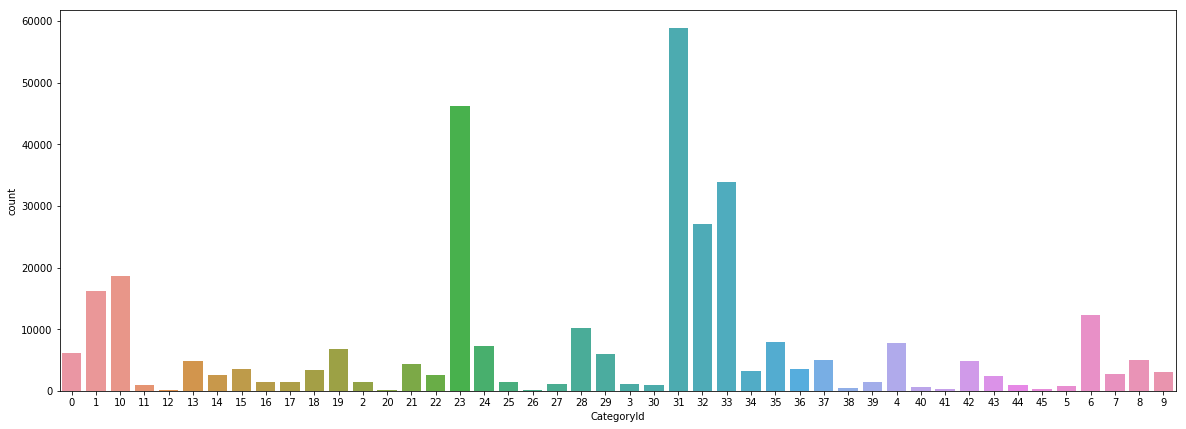

In [9]:
plt.figure(figsize=(20, 7))
sns.countplot(train_df['CategoryId']);

Moreover in our dataframe we have to have unique pair (ImageId, ClassId) but in our initial dataframe we have each pair for each mask segment.
In the following example we have duplicates with ClassId - 31, 32

In [10]:
train_df[train_df['ImageId'] == '00000663ed1ff0c4e0132b9b9ac53f6e.jpg']

,ImageId,EncodedPixels,Height,Width,ClassId,CategoryId
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676,6,6
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676,0,0
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676,28,28
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676,31,31
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676,32,32
5,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,11464158 10 11469372 30 11474586 43 11479800 4...,5214,3676,32,32
6,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,5910568 31 5915775 65 5920982 69 5926189 73 59...,5214,3676,31,31
7,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6421446 292 6426657 298 6431867 305 6437078 31...,5214,3676,29,29
8,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,4566382 8 4571592 25 4576803 41 4582013 58 458...,5214,3676,4,4


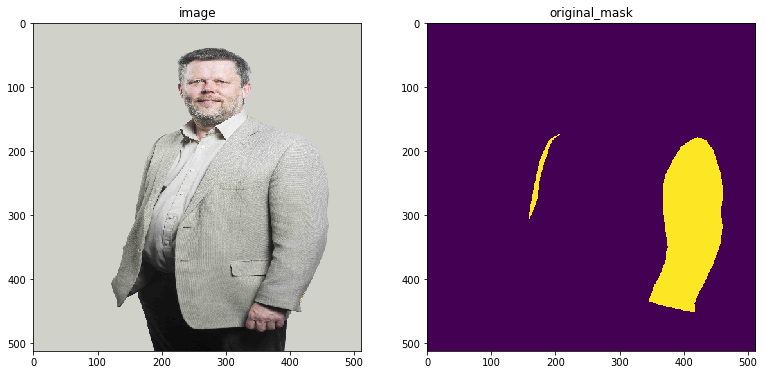

In [11]:
visualise_masks('00000663ed1ff0c4e0132b9b9ac53f6e.jpg', train_df, im_class='31')

So lets fix it

In [12]:
def get_unique_class_id_df(inital_df):
    temp_df = inital_df.groupby(['ImageId','ClassId'])['EncodedPixels'].agg(lambda x: ' '.join(list(x))).reset_index()
    size_df = inital_df.groupby(['ImageId','ClassId'])['Height', 'Width'].mean().reset_index()
    temp_df = temp_df.merge(size_df, on=['ImageId','ClassId'], how='left')
    
    return temp_df

In [13]:
train_df = get_unique_class_id_df(train_df)

In [14]:
train_df[train_df['ImageId'] == '00000663ed1ff0c4e0132b9b9ac53f6e.jpg']

,ImageId,ClassId,EncodedPixels,Height,Width
0,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,0,6323163 11 6328356 32 6333549 53 6338742 75 63...,5214,3676
1,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,28,8521389 10 8526585 30 8531789 42 8537002 46 85...,5214,3676
2,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,29,6421446 292 6426657 298 6431867 305 6437078 31...,5214,3676
3,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,31,12903854 2 12909064 7 12914275 10 12919485 15 ...,5214,3676
4,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,32,10837337 5 10842542 14 10847746 24 10852951 33...,5214,3676
5,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,4,4566382 8 4571592 25 4576803 41 4582013 58 458...,5214,3676
6,00000663ed1ff0c4e0132b9b9ac53f6e.jpg,6,6068157 7 6073371 20 6078584 34 6083797 48 608...,5214,3676


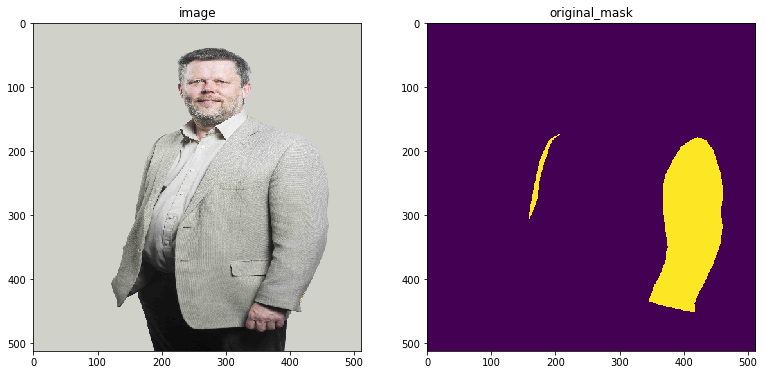

In [15]:
visualise_masks('00000663ed1ff0c4e0132b9b9ac53f6e.jpg', train_df, im_class='31')

# Train/Test split

Of course, it is better to have train/validation/test datasets. But now we will stop on train/test. Why?
* We do not have Early Stopping and other stuff, that will overfit us
* Orgs did not clarify this point properly 

We will make train/test split on Classid combinations 

In [16]:
def create_one_represent_class(df_param):
    v_c_df = df_param['CategoryId'].value_counts().reset_index()
    one_represent = v_c_df.loc[v_c_df['CategoryId'] == 1, 'index'].tolist()
    df_param.loc[df_param['CategoryId'].isin(one_represent), 'CategoryId'] = 'one_represent'
    return df_param

def custom_train_test_split(df_param):
    
    df_param['CategoryId'] = df_param.ClassId.apply(lambda x: str(x).split("_")[0])
    
    img_categ = train_df.groupby('ImageId')['CategoryId'].apply(list).reset_index()
    img_categ['CategoryId'] = img_categ['CategoryId'].apply(lambda x: ' '.join(sorted(x)))
    
    img_categ = create_one_represent_class(img_categ)
    
    img_train, img_val  = train_test_split(img_categ, test_size=0.2, random_state=42, stratify=img_categ['CategoryId'])
    
    df_param = df_param.drop(columns='CategoryId')
    
    df_train = df_param[df_param['ImageId'].isin(img_train['ImageId'])].reset_index(drop=True)
    df_val = df_param[df_param['ImageId'].isin(img_val['ImageId'])].reset_index(drop=True)
    
    return df_train, df_val

In [17]:
train_df = pd.read_csv(DF_PATH_TRAIN)
train_df, val_df = custom_train_test_split(train_df)

train_df = get_unique_class_id_df(train_df)
val_df = get_unique_class_id_df(val_df)

Lets take a look on our categoryid distribution

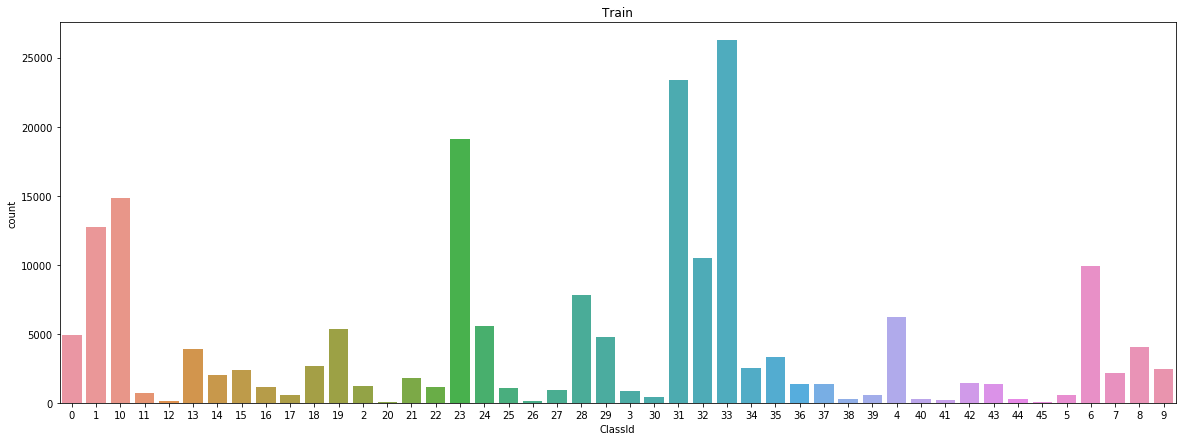

In [18]:
plt.figure(figsize=(20, 7))
plt.title('Train')
sns.countplot(train_df['ClassId'].apply(lambda x: str(x).split("_")[0]));

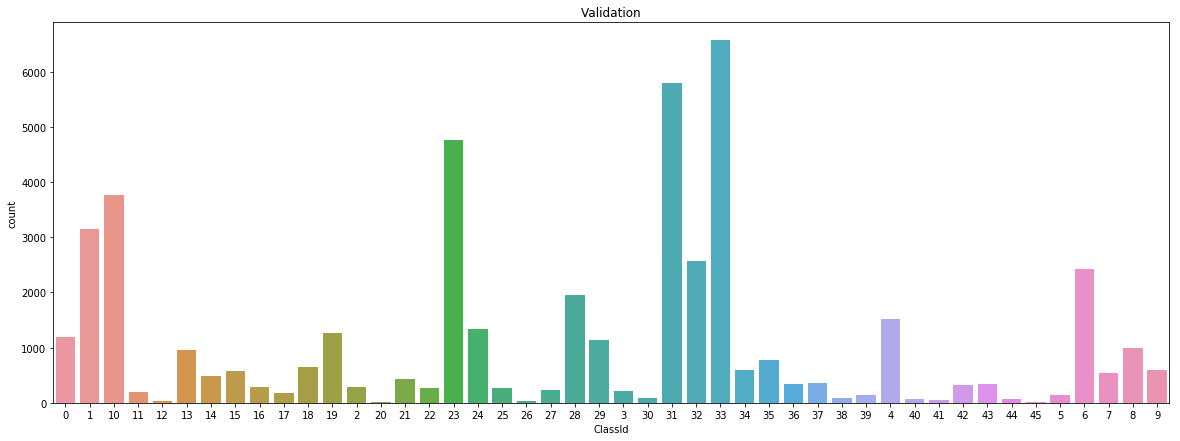

In [19]:
plt.figure(figsize=(20, 7))
plt.title('Validation')
sns.countplot(val_df['ClassId'].apply(lambda x: str(x).split("_")[0]));

Awesome matching !!!

So now we are ready for DEEEEEEEEEEEEEEEEEEEEEEEEEEEEEep Learning

![](https://pbs.twimg.com/media/CnN1pRvUAAA0lWq.jpg)

# DL part

We will use classical Unet architecture with mobilenet backbone, pretrained on ImageNet. Why ?
* Unet is classic
* Backbone is light enough to train it in Kaggle Kernel

![Unet](https://i.stack.imgur.com/DjXVU.png)

![](http://static.issue.life/Content/img/17-03-2019/636884100747932656.png)

We have trained our Net only for 2 epochs (Kaggle Kernel limitation on time)
* With Dice Loss
* With Horizontal and Vertical flip augmentations
* With Adam optimizer
* Data was normalized by ImageNet stats

## Dataset

In [20]:
class UnetDataset(torch.utils.data.Dataset):
    def __init__(self, image_dir, df, height, width, augmentation=None, preprocessing=None):
        
        self.preprocessing = preprocessing
        self.augmentation = augmentation
        
        self.image_dir = image_dir
        self.df = df
        
        self.height = height
        self.width = width
        
        self.image_info = collections.defaultdict(dict)
        
        self.df['CategoryId'] = self.df.ClassId.apply(lambda x: str(x).split("_")[0])
        self.num_classes = self.df['CategoryId'].nunique()
        
        temp_df = self.df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x)).reset_index()
        size_df = self.df.groupby('ImageId')['Height', 'Width'].mean().reset_index()
        temp_df = temp_df.merge(size_df, on='ImageId', how='left')
        
        for index, row in tqdm(temp_df.iterrows(), total=len(temp_df)):
            image_id = row['ImageId']
            image_path = os.path.join(self.image_dir, image_id)
            self.image_info[index]["image_id"] = image_id
            self.image_info[index]["image_path"] = image_path
            self.image_info[index]["width"] = self.width
            self.image_info[index]["height"] = self.height
            self.image_info[index]["labels"] = row["CategoryId"]
            self.image_info[index]["orig_height"] = row["Height"]
            self.image_info[index]["orig_width"] = row["Width"]
            self.image_info[index]["annotations"] = row["EncodedPixels"]

    def __getitem__(self, idx):
        
        img_path = self.image_info[idx]["image_path"]
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.width, self.height))
        
        # apply preprocessing
        if self.preprocessing is not None:
            img = self.preprocessing(image=img)['image']
            
        return img, os.path.basename(img_path)

    def __len__(self):
        return len(self.image_info)

## Preprocessing

In [21]:
def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

## Model

In [22]:
ENCODER = 'mobilenet_v2'
ENCODER_WEIGHTS = 'imagenet'
DEVICE = 'cuda'

ACTIVATION = 'sigmoid'

In [23]:
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=46, 
    activation=ACTIVATION,
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 31.9MB/s]


In [24]:
model.load_state_dict(torch.load(PATH_TO_MODEL_WEIGHTS, 
                                 map_location=torch.device(DEVICE)))

<All keys matched successfully>

In [25]:
model = model.to(DEVICE)
model.eval();

# Dataloader

In [26]:
test_dataset = UnetDataset(
    ROOT_PATH_TRAIN,
    val_df,
    IAMGE_PREDICTION_SIZE[0],
    IAMGE_PREDICTION_SIZE[0], 
    preprocessing=get_preprocessing(preprocessing_fn),
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

/opt/conda/lib/python3.6/site-packages/albumentations/augmentations/transforms.py:2908: UserWarning: Using lambda is incompatible with multiprocessing. Consider using regular functions or partial().
  "Using lambda is incompatible with multiprocessing. "
100%|██████████| 9039/9039 [00:01<00:00, 4898.03it/s]


# Inference

In [27]:
def create_final_df(result_dict):
    final_df = {'ImageId':[], 'EncodedPixels':[], 'ClassId':[]}
    for im_name, im_dict in result_dict.items():
        final_df['ImageId'] += [im_name]*len(im_dict)
        for cls_id, enc_p in im_dict.items():
            final_df['EncodedPixels'].append(enc_p)
            final_df['ClassId'].append(cls_id)
            
    return pd.DataFrame(final_df)

class InfernceModel(object):
    def __init__(self, nn_model, device, output_size=(512,512), threshold=0.5, size_min_mask=250):
        self.nn_model = nn_model
        self.output_size = output_size
        self.threshold = threshold
        self.size_min_mask = size_min_mask
        self.device = device
        
    def __call__(self, inf_dataloader):
        result = {}
        with torch.no_grad():
            for batch in tqdm(inf_dataloader, 
                              total=len(inf_dataloader.dataset) // inf_dataloader.batch_size):
                names = batch[1]
                batch = model(batch[0].to(self.device)).detach().cpu().numpy()
                for idx in range(batch.shape[0]):
                    cur_result = self.post_process(batch[idx])
                    if len(cur_result) > 0:
                        result[names[idx]] = cur_result
                        
        final_df = create_final_df(result) 
        final_df['Height'] = self.output_size[0]
        final_df['Width'] = self.output_size[1]
        final_df['ClassId'] = final_df['ClassId'].astype(str)
                    
        return final_df
        
    def post_process(self, mask):
        rle_mask = {}
        for idx in range(mask.shape[0]):
            item_mask = mask[idx]
            
            item_mask = (item_mask > self.threshold).astype(np.uint8)
            item_mask = cv2.resize(item_mask, self.output_size)
            
            if item_mask.sum() < self.size_min_mask:
                continue
            else:
                rle_mask[str(idx)] = rle_encode(item_mask)
            
        return rle_mask

In [28]:
inf_model = InfernceModel(nn_model=model, device=DEVICE)

In [29]:
predicted_df = inf_model(test_loader)

283it [14:53,  3.16s/it]


In [30]:
predicted_df.head()

,ImageId,EncodedPixels,ClassId,Height,Width
0,000b3a87508b0fa185fbd53ecbe2e4c6.jpg,129159 10 129671 10 130181 14 130693 14 131201...,1,512,512
1,000b3a87508b0fa185fbd53ecbe2e4c6.jpg,75177 32 75689 32 76195 42 76707 42 77217 46 7...,10,512,512
2,000b3a87508b0fa185fbd53ecbe2e4c6.jpg,72093 2 72605 2 73111 16 73623 16 74133 30 746...,31,512,512
3,000cd2e13d1bdd28f480304d7bb9e1ca.jpg,152749 4 153261 4 153771 8 154283 8 154797 6 1...,4,512,512
4,000cd2e13d1bdd28f480304d7bb9e1ca.jpg,69823 4 70335 4 70841 12 71353 12 71861 16 723...,10,512,512


## Evaluate results

### Visualize

Firstly, on all classes together

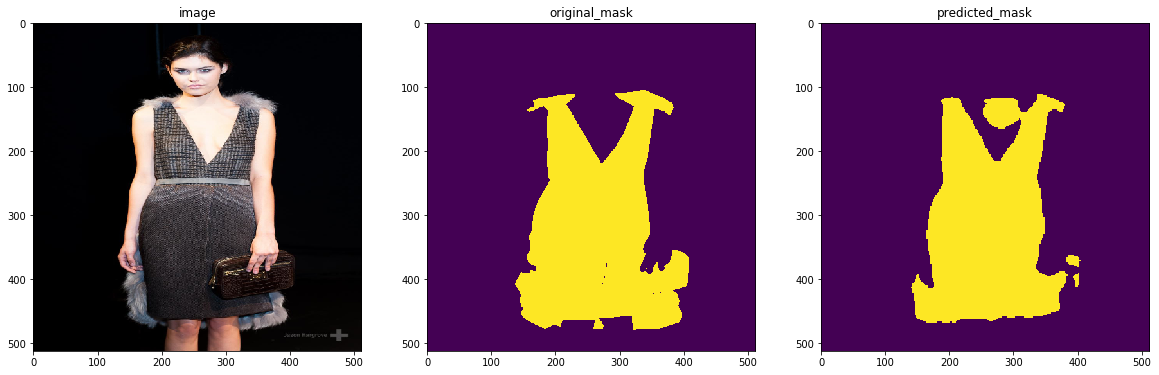

In [31]:
visualise_masks('000b3a87508b0fa185fbd53ecbe2e4c6.jpg', val_df, predicted_df)

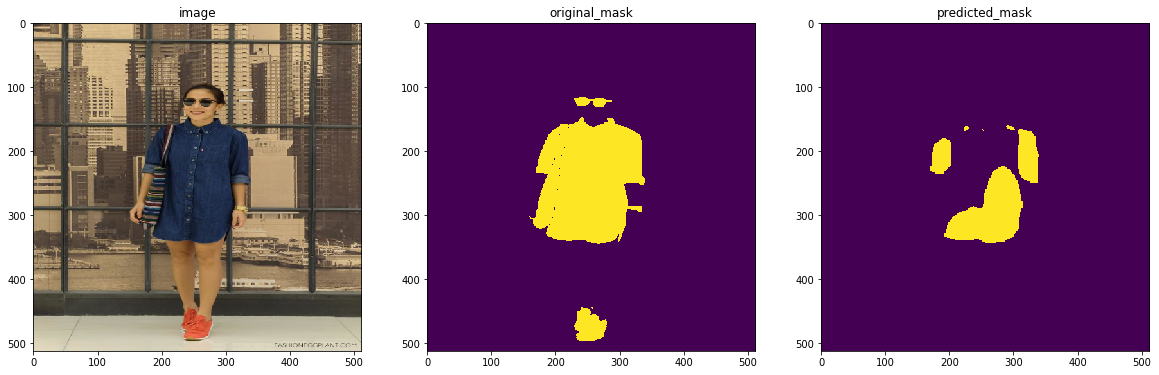

In [32]:
visualise_masks('fffc631acce2e28e1628de685d40c980.jpg', val_df, predicted_df)

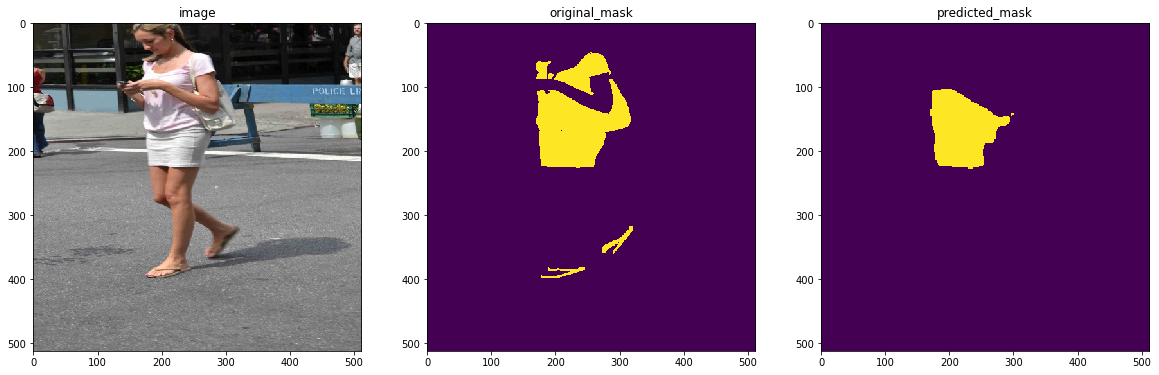

In [33]:
visualise_masks('ffec8295f37df6ea12eecbb60d2c23d4.jpg', val_df, predicted_df)

So we get some main cloth parts

Now lets look at different CategoryID

Firstly, on some frequent

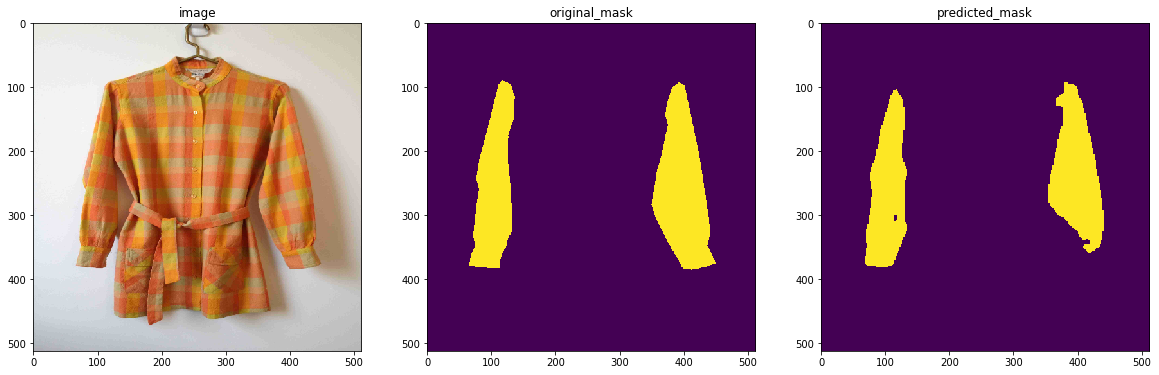

In [34]:
visualise_masks('001039acb67251508b1b32fd37a49f43.jpg', val_df, predicted_df, im_class='31')

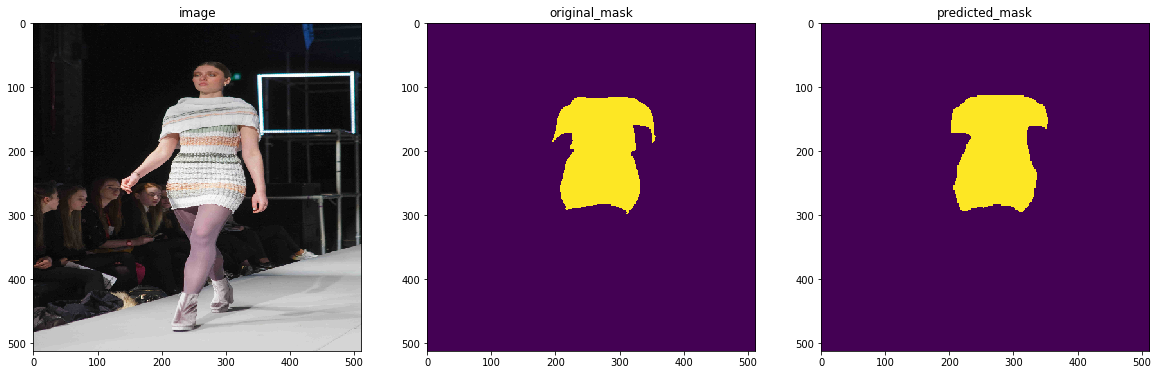

In [35]:
visualise_masks('005ccdb239e2d6cfe62506dd6eb5693e.jpg', val_df, predicted_df, im_class='10')

Got it. Also these masks are huge enough for our week net

But as for smaller masks and less frequent

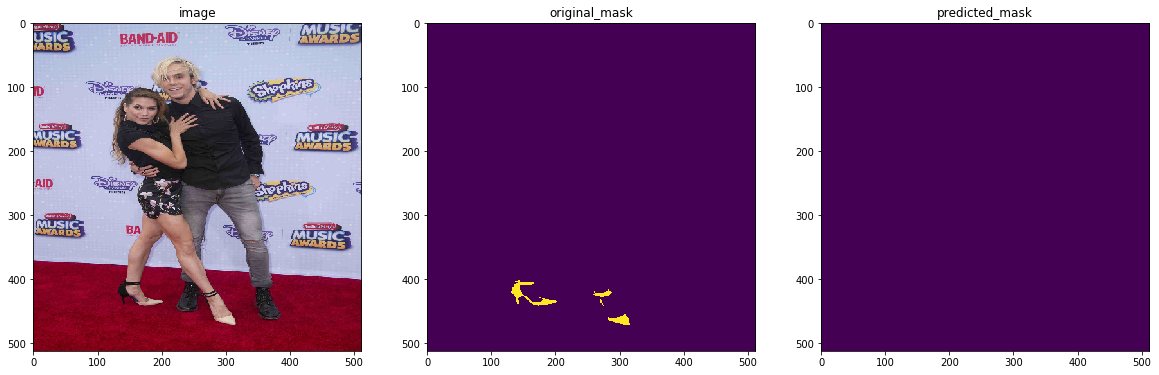

In [36]:
visualise_masks('000cd2e13d1bdd28f480304d7bb9e1ca.jpg', val_df, predicted_df, im_class='23')

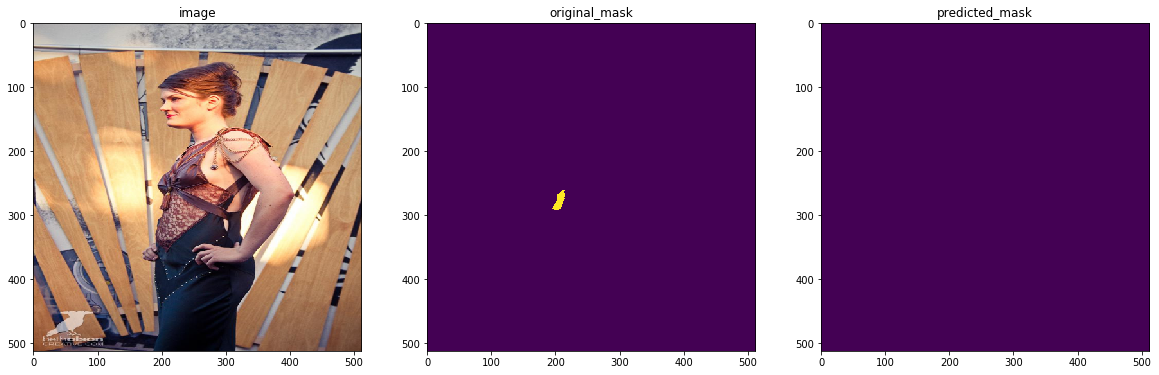

In [37]:
visualise_masks('05e6ef19957d43524d972de6d2f41b57.jpg', val_df, predicted_df, im_class='45')

Not very good results for these masks

### Metric

In [38]:
# mainly from here https://www.kaggle.com/kyazuki/calculate-evaluation-score

def IoU(A,B):
    AorB = np.logical_or(A,B).astype('int')
    AandB = np.logical_and(A,B).astype('int')
    IoU = AandB.sum() / AorB.sum()
    return IoU

def IoU_threshold(data):
    # Note: This rle_to_mask should be called before loop below for speed-up! We currently implement here to reduse memory usage.
    mask_gt = rle_decode(data['EncodedPixels_true'], (int(data['Height_true']), int(data['Width_true'])))
    mask_pred = rle_decode(data['EncodedPixels_pred'], (int(data['Height_pred']), int(data['Width_pred'])))\
    
    if (int(data['Height_true']), int(data['Width_true'])) != IMAGE_SIZE:
        mask_gt = cv2.resize(mask_gt, IMAGE_SIZE)
    if (int(data['Height_pred']), int(data['Width_pred'])) != IMAGE_SIZE:
        mask_pred = cv2.resize(mask_pred, IMAGE_SIZE)
    
    mask_gt = mask_gt > 0.5
    mask_pred = mask_pred > 0.5
    
    return IoU(mask_gt, mask_pred)

def best_metric(true_df, pred_df):
    eval_df = pd.merge(true_df, pred_df, how='outer', on=['ImageId', 'ClassId'], suffixes=['_true', '_pred'])

    # IoU for True Positive
    idx_ = eval_df['EncodedPixels_true'].notnull() & eval_df['EncodedPixels_pred'].notnull()
    IoU = eval_df[idx_].apply(IoU_threshold, axis=1)

    # False Positive
    fp = (eval_df['EncodedPixels_true'].isnull() & eval_df['EncodedPixels_pred'].notnull()).sum()

    # False Negative
    fn = (eval_df['EncodedPixels_true'].notnull() & eval_df['EncodedPixels_pred'].isnull()).sum()

    threshold_IoU = np.arange(0.5, 1.0, 0.05)
    scores = []
    for th in threshold_IoU:
        # True Positive
        tp = (IoU > th).sum()
        iou_fp = (IoU <= th).sum()

        # False Positive (not Ground Truth) + False Positive (under IoU threshold)
        fp = fp + iou_fp

        # Calculate evaluation score
        score = tp / (tp + fp + fn)
        scores.append(score)

    mean_score = sum(scores) / len(threshold_IoU)
    return mean_score

Lets test it

In [39]:
images_to_count_metric = val_df['ImageId'].unique()[:100]

best_metric(val_df[val_df['ImageId'].isin(images_to_count_metric)], val_df[val_df['ImageId'].isin(images_to_count_metric)])

1.0

And now evaluate our prediction

In [40]:
best_metric(val_df, predicted_df)

0.06120043033149062

## What can be improved

EVERYTHING

* Use MaskRCNN or other appropriate architecture for biag amount of classes
* Use bigger backbone
* Train until Net converged
* Use bigger augmentations
* Tune net hyperparams
* Use TwoHead Net
* Use Test Time Augmentations
* Use Blending

And so on ....

Why we did not do all this stuff

Because

* 30 hours per week of railway
* one GPU per account
* execution - up to 6 hours

# Final thoughts or kozaki pishut pismo BESTu

![](https://zaxid.net/resources/photos/news/640x360_DIR/201511/1371769.jpg?201805281755)

We think that such format of test task is one of the worst variants. Why ?
* This task requires Deep Learning background, which is overkill for contest, where most participants are students 
* Even if participant has Deep Learning background, he/she will need a lot of computational resources (GPUs), which cost money or use his/her GPU Quota on Kaggle
* Metric and Train/Test were not provided. So all participants will have hardly biased results. It is important, because evaluating DL/ML/DS tasks by 'beautiful code' or 'interesting approach' or something like this is not the best practice. Of course, these criteria should be taken into account, but main criteria is target metric !